Since it's the easiest non-trivial way to learn the basics, let's use PyTorch to train a somewhat sophisticated CIFAR-10 classifier.

In [1]:
import matplotlib.pyplot as plt
import network
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

First, let's figure out if we have a CUDA GPU to use.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Getting data

Thankfully, PyTorch has a simple getter function for CIFAR-10/100 which will handle the downloading and turning into a PyTorch Dataset object which returns PIL Images. First, we must define the image transforms we'll apply to the training and test datasets. We will always turn the Image into a PyTorch tensor, and normalize so that all images fall between $\pm 1$. If we want to do data augmentation, for the training set we will first perform random left-right flips and padding+random cropping.

In [3]:
augment_data = True
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
base_transforms = [transforms.ToTensor(), transforms.Normalize(mean, std)]
aug_transforms = [transforms.RandomHorizontalFlip(p=0.5),
                  transforms.RandomCrop(32, padding=4)]
test_transform = transforms.Compose(base_transforms)
if augment_data:
    train_transform = transforms.Compose(aug_transforms+base_transforms)
else:
    train_transform = test_transform

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_data = torchvision.datasets.CIFAR10('./data', download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


Create dataloaders to iterate and shuffle the data. Because PyTorch's automatic CIFAR-10 loaders only give the full 50k image training set (no validation split), we'll use random samplers to subdivide this at dataload time into.

You'll notice something slightly abnormal here, which is that now the validation set will be randomly augmented just like the training set. This is typically not done, but the only way around it here is to either write my own CIFAR-10 loader or load a second, full copy of the training set without augmentation. The first is annoying, and the second just seems wasteful (yes, yes, I know, it's only ~150 MB, but still...). 

This may be a bad thing, but I'm not actually sure how much. In principle, if we were to optimize the hyperparameters to best work on new *augmented* data, it may be suboptimal for generalizing to new un-augmented data. However, given the nature of the augmentation here (left/right flips, random pads/crops), which will mostly shift how centered the objects are and their orientation, it seems extremely unlikely that something which gives the best validation score wouldn't also give the best test score.

Either way, my main goal here is to just get the hang of doing some training in PyTorch, so...*meh*.

In [5]:
batch_size = 128
val_size = 5000

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

if val_size>0:
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = num_train-val_size

    train_idx, val_idx = indices[:split], indices[split:]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
    train_val_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                                   sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                                   sampler=val_sampler)

Let's look at some images. We'll make a little helper function

In [6]:
def imshow(img):
    img = img/2+0.5
    np_img = img.numpy()
    plt.figure(figsize=(16,2))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')

and look at the training dataset (note the black borders due to random padding and cropping, if we augmented)

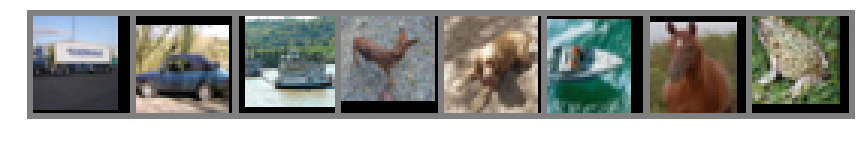

In [7]:
train_samples = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
data_iter = iter(train_samples)
images, _ = data_iter.next()
imshow(torchvision.utils.make_grid(images))

and the test dataset (note the lack of augmentation)

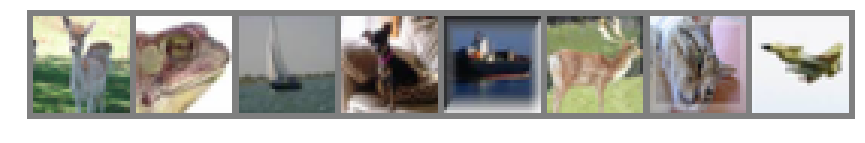

In [8]:
test_samples = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
data_iter = iter(test_samples)
images, _ = data_iter.next()
imshow(torchvision.utils.make_grid(images))

In [9]:
image_shape = images.numpy().shape[1:]

# Training

Okay, let's define our model, loss function, all that jazz. We're using the ResNeXt architecture here, taking architecture and hyperparameters stright out of the original paper (Xie et al., arXiv:1611.05431v2), just going straight for maximum cardinality (16 sets of channels at each residual block), which should get us to something like 97% test accuracy.

In [10]:
learning_rate = 0.1
reg_strength = 5e-4

In [26]:
model = network.ResNeXt(image_shape, 64, [3, 3, 3], 16, len(classes))
model.to(device) # don't forget to move the model to the GPU before defining the optimizer!
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=reg_strength, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [150, 225], gamma=0.1)

In [16]:
num_epochs = 1
print_every = 100
loss_curve, acc_train = [], []
acc_test = []
for epoch in range(num_epochs):
    scheduler.step()
    model.train()
    for idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
        loss_curve.append(loss.item)
        _, predicted = torch.max(logits.item(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc_train.append(correct/total)
        
        if idx % print_every == 0:
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch+1, idx+1, loss.item, correct/total))
        
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            _, predicted = torch.max(logits.item(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc_test.append(correct/total)  